In [1]:
%matplotlib inline

In [2]:
import os
import os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import wavfile
from scipy.fftpack import fft
from pylab import *
import wave as wv
import numpy as np
import random
import ntpath

In [3]:
def read_script(transacript_file_path):
    txt = open(transacript_file_path)
    content = txt.read()
    txt.close()
    return content

In [4]:
def show_image(image_file_path):
    img1 = mpimg.imread(image_file_path)
    plt.imshow(img1)
    plt.close

In [5]:
def get_files(root_dir, file_type):
    retVal = []
    for root, dirs, files in os.walk(root_dir):
        for name in [ fi for fi in files if fi.endswith(file_type) ]:
            retVal.append(os.path.join(root, name))
            
    return retVal

In [6]:
files_8element = get_files('../multimic_converted/8element/', '.wav')
files_15element = get_files('../multimic_converted/15element/', '.wav')
files_rutdata = get_files('../multimic_converted/rutdata/', '.wav')

print "8element", len(files_8element)
print "15element", len(files_15element)
print "rutdata", len(files_rutdata)

print "total file count", len(files_8element) + len(files_15element) + len(files_rutdata)

files_transcripts_rutdata = get_files('../multimic_converted/rutdata/transcripts/', '.sent')
files_transcripts_main = get_files('../multimic_converted/transcripts/', '.sent')

print "transcripts count rutdata", len(files_transcripts_rutdata)
print "tranacripts count main", len(files_transcripts_main)

print "total transacripts count", len(files_transcripts_rutdata) + len(files_transcripts_main)


8element 392
15element 157
rutdata 466
total file count 1015
transcripts count rutdata 468
tranacripts count main 546
total transacripts count 1014


In [7]:
def getMetadata(filename):
    w_read = wv.open(filename)
    print "# of Channels:", w_read.getnchannels();
    print "Sample Width", w_read.getsampwidth();
    print "Frame Rate: (# of samples per second) ", w_read.getframerate();
    print "# of Frames (samples):", w_read.getnframes();
    print "Total time seconds:", w_read.getnframes() * 1.0 / w_read.getframerate();
    print "Total time milliseconds:", w_read.getnframes() * 1.0 / w_read.getframerate() * 1000;
    print "Compression Type:", w_read.getcomptype();
    print "Compression Name:", w_read.getcompname();
    w_read.close()

In [8]:
rand_8elem_file = random.choice(files_8element)
print "===> 8elem file:", rand_8elem_file
getMetadata(rand_8elem_file);

rand_15elem_file = random.choice(files_15element)
print "===> 15elem file:", rand_15elem_file
getMetadata(rand_15elem_file);

===> 8elem file: ../multimic_converted/8element/mtms/cen5-mtms-pzmS.adc.wav
# of Channels: 1
Sample Width 2
Frame Rate: (# of samples per second)  16000
# of Frames (samples): 64005
Total time seconds: 4.0003125
Total time milliseconds: 4000.3125
Compression Type: NONE
Compression Name: not compressed
===> 15elem file: ../multimic_converted/15element/an105-mtms-arrC1A.adc_.wav
# of Channels: 15
Sample Width 2
Frame Rate: (# of samples per second)  16000
# of Frames (samples): 33280
Total time seconds: 2.08
Total time milliseconds: 2080.0
Compression Type: NONE
Compression Name: not compressed


In [9]:
# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
# http://stackoverflow.com/questions/23377665/python-scipy-fft-wav-files
def display_time_domain(file_wave):
    sampFreq, snd = wavfile.read(file_wave);
    print "Sampled Per Second:", sampFreq
    print snd.dtype
    snd = snd / (2.**15) # Normalize to -1 to 1
    print "Sound Data Shape", snd.shape
    if len(snd.shape) > 1:
        (sample_points, _) = snd.shape
        sound = snd[:,0] 
    else:
        sample_points = len(snd)
        sound = snd

    print "Sample Points:", sample_points
    print "Total Time (ms):", sample_points * 1.0 / sampFreq * 1000.0

    timeArray = arange(0, sample_points * 1.0, 1)
    timeArray = timeArray / sampFreq * 1000.0

    plt.figure(figsize = (10,10))
    plt.plot(timeArray, sound)
    ylabel('Amplitude')
    xlabel('Time (ms)')
    plt.close()

In [10]:
import soundfile as sf
import sounddevice as sd

def play_file(file_name):
    sig, fs = sf.read(file_name)
    sd.play(sig, fs)

In [11]:
play_file(rand_8elem_file)

In [12]:
play_file(rand_15elem_file)

PortAudioError: Error opening OutputStream: Invalid number of channels

In [13]:
def processVV(file_name, show, save, log=False):
    sampFreq, snd = wavfile.read(file_name);
    if log:
        print "Sampled Per Second:", sampFreq
        print snd.dtype
    snd = snd / (2.**15) # Normalize to -1 to 1
    
    if log:
        print "Sound Data Shape", snd.shape
        
    if len(snd.shape) > 1:
        (sample_points, _) = snd.shape
        sound = snd[:,0]
    else:
        sample_points = len(snd)
        sound = snd

    if log:
        print "Sample Points:", sample_points
        print "Total Time (ms):", sample_points * 1.0 / sampFreq * 1000.0

    timeArray = arange(0, sample_points * 1.0, 1)
    timeArray = timeArray / sampFreq * 1000.0

    chunkSize = 160 # 1/10 times of the sampling rate
    chunks = [sound[i:i+chunkSize] for i in xrange(0, len(sound), chunkSize)]

    nUniquePts = int(ceil((chunkSize+1)/2.0))
    output = zeros((nUniquePts,len(chunks[:-1])))
    i = 0;
    for chunk in chunks[:-1]:
        p = fft(chunk)
        p = p[0:nUniquePts]
        p = abs(p)

        p = p / float(chunkSize)
        p = p**2
        if chunkSize % 2 > 0:
            p[1:len(p)] = p[1:len(p)] * 2
        else:
            p[1:len(p) -1] = p[1:len(p) - 1] * 2

        logp = 10*log10(p)
        logp = logp - min(logp)
        logp = logp / max(logp) * 255

        output[:,i] = logp
        i += 1

    plt.figure(figsize = (10,10))
    
    if save:
        plt.imsave(file_name + '.png', output, cmap=plt.get_cmap('gray'))
        
    if show:
        plt.imshow(output, cmap=plt.get_cmap('gray'))
    
    plt.close()
    
    if log:
        print output.shape

In [14]:
display_time_domain(rand_8elem_file)
processVV(rand_8elem_file, True, False)

Sampled Per Second: 16000
int16
Sound Data Shape (64005,)
Sample Points: 64005
Total Time (ms): 4000.3125


In [15]:
display_time_domain(rand_15elem_file)
processVV(rand_15elem_file, True, False)

Sampled Per Second: 16000
int16
Sound Data Shape (33280, 15)
Sample Points: 33280
Total Time (ms): 2080.0


In [16]:
def convert(input_collection):
    for file_name in input_collection:
        processVV(file_name, False, True)

    print 'Done!'

In [ ]:
convert(files_8element)

In [ ]:
convert(files_15element)

In [ ]:
convert(files_rutdata)

In [17]:
def match_items(wave_root_folder, img_root_folder, transacript_root_folder):
    wave_files = get_files(wave_root_folder, '.wav')
    img_files = get_files(img_root_folder, '.png')
    trans_files = get_files(transacript_root_folder, '.sent')
    
    print "# of wave files:", len(wave_files)
    print "# of image files:", len(img_files)
    print "# of transacript files:", len(trans_files)

    output = []
    for wave_file in wave_files:
        file_name = ntpath.basename(wave_file).split('.')[0];
        img_file_name_list = [s for s in img_files if file_name in s]
        transacript_file_name_list = [s for s in trans_files if file_name in s]
        
        image_file = ''
        trans_file = ''
        
        if img_file_name_list:
            image_file = img_file_name_list[0]

        if transacript_file_name_list:
            trans_file = transacript_file_name_list[0]
            
        output.append((wave_file, image_file, trans_file))
        
    return output

In [18]:
elem_15 = match_items('../multimic_converted/15element/', './15element/', './transcripts/')
elem_8 = match_items('../multimic_converted/8element/', './8element/', './transcripts/')
rut_data = match_items('../multimic_converted/rutdata/', './rutdata/', './rutdata/transcripts/')

# of wave files: 157
# of image files: 157
# of transacript files: 546
# of wave files: 392
# of image files: 392
# of transacript files: 546
# of wave files: 466
# of image files: 466
# of transacript files: 468


../multimic_converted/8element/mejs/an149-mejs-senn.adc.wav
./8element/mejs/an149-mejs-senn.adc.wav.png
./transcripts/an149-mejs-senn.sent
ENTER NINE EIGHTY NINE



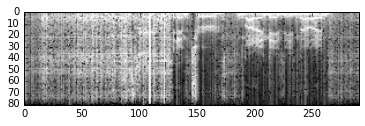

In [20]:
wave_file, image_file, transacript_file = random.choice(elem_8)

print wave_file
print image_file
print transacript_file

play_file(wave_file)
show_image(image_file)
print read_script(transacript_file)